In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import gurobipy as gp
import math
import re
from gurobipy import *

|Estudiante|Código|Correo|
|-----|-----|----|
|Juana Mejía Botero|20221512|j.mejia17|
|Daniela Ricaurte Echeverry|201822966|d.ricaurte|

# Proyecto - Entrega 3


## Lectura de datos

In [2]:
# Datos globales del grafo
datos_globales = {}

# Nodos del grafo
nodos = []

# Demanda de potencia activa de los nodos
pd = {}
# Demanda de potencia reactiva de los nodos
qd = {}

# Resistencia de los arcos
r = {}
# Reactancia de los arcos
x = {}
# Arcos
B = []

In [3]:

def lecturaDocumentoDB():
    
    #Valores globales    
    patterns = {
        'nref': r'nref\s*=\s*([\d.]+);',
        'vref': r'vref\s*=\s*([\d.]+);',
        'vbase': r'vbase\s*=\s*([\d.]+);',
        'sbase': r'sbase\s*=\s*([\d.]+);',
        'tol': r'tol\s*=\s*([\d.^-]+);', 
        'vmin': r'vmin\s*=\s*([\d.]+);',
        'vmax': r'vmax\s*=\s*([\d.]+);',
        'zbase': r'zbase\s*=\s*([\d.]+);',
    }
    
    branch_pattern = r'ramos\s*=\s*\[(.*?)\];'
    bus_demand_pattern = r'barras\s*=\s*\[(.*?)\];'
    
    branches = []
    bus_demand = []
    
    file_path = "/Users/juanamejia/Desktop/uni/SVII/FR/ProyectoFlujoEnRedes/datos14.txt"
    #input('Ingresar el path del archivo \n')
    
    with open(file_path, "r",encoding='latin1') as file:
        text = file.read()
    

    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            if key == 'tol':
                base, exponent = match.group(1).split('^')
                datos_globales[key] = float(base) * 10 ** int(exponent)
            else:
                datos_globales[key] = float(match.group(1))
    
    
    
    # Datos de ramas      
    match = re.search(branch_pattern, text, re.DOTALL)
    if match:
        branch_data = match.group(1)

        
        branch_lines = branch_data.split('\n')
        branch_lines = [line.strip() for line in branch_lines if not line.strip().startswith('%')]

       
        for line in branch_lines:
            valores = line.split()
            if len(valores) == 4:
                branch = [float(valor) for valor in valores]
                branches.append(branch)
                
    # Datos de la demanda de potencia activa y reactiva en las barras
    match = re.search(bus_demand_pattern, text, re.DOTALL)
    if match:
        bus_demand_data = match.group(1)

       
        bus_demand_lines = bus_demand_data.split('\n')
        bus_demand_lines = [line.strip() for line in bus_demand_lines if not line.strip().startswith('%')]

       
        for line in bus_demand_lines:
            valores = line.split()
            if len(valores) >= 4:
                bus = [int(valores[0]), float(valores[1]), float(valores[2]), float(valores[3])]
                bus_demand.append(bus)
    
    # Editar los valores
    numNodos(datos_globales.get("nref"))
    potencias(bus_demand)
    impedencia(branches)
    
    

def numNodos(n):
    for i in range (1,int(n)+1):
        nodos.append(i)
    


def potencias(demand):
    for bus in demand:
        pd[(bus[0])] = bus[1]
        qd[( bus[0])] = bus[2]
      
        
def impedencia(branches): 
    for branch in branches:
        from_node = int(branch[0])
        to_node = int(branch[1])
        
        
        B.append( (from_node, to_node))
        B.append( ( to_node, from_node))
        r[( from_node, to_node)] = branch[2]*0.01
        r[( to_node, from_node)] = branch[2]*0.01
        x[( from_node, to_node)] = branch[3]*0.01
        x[( to_node, from_node)] = branch[3]*0.01


lecturaDocumentoDB()

In [4]:
print(nodos)
for i in nodos:
    print(pd[i])

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
2100.0
1000.0
1000.0
1000.0
4500.0
600.0
1000.0
5000.0
4000.0
1500.0
2000.0
3000.0
2000.0
0.0


## Visualización de los datos

In [5]:
def printDatos():
    print("Nodos")
    print(nodos)
    
    print("Datos Globales")
    for key, value in datos_globales.items():
        print(f"{key}: {value}")
    
    print("Demanda de potencia Activa(pd)")
    for key, value in pd.items():
        print(key, value)


    print("Demanda de Potencia Reactiva(qd)")
    for key, value in qd.items():
        print(key, value)
    
    print("Resistencia(r) de los arcos")
    for key, value in r.items():
        print(key, value)
    
    print("Reactancia(x) de los arcos")
    for key, value in x.items():
        print(key, value)
        
    print("Arcos")
    print(B)

printDatos()
    

Nodos
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
Datos Globales
nref: 14.0
vref: 1.0
vbase: 23.0
sbase: 100000.0
tol: 1e-07
vmin: 0.93
vmax: 1.05
zbase: 100.0
Demanda de potencia Activa(pd)
14 0.0
13 2000.0
12 3000.0
11 2000.0
10 1500.0
9 4000.0
8 5000.0
7 1000.0
6 600.0
5 4500.0
4 1000.0
3 1000.0
2 1000.0
1 2100.0
Demanda de Potencia Reactiva(qd)
14 0.0
13 1600.0
12 1500.0
11 800.0
10 1200.0
9 2700.0
8 3000.0
7 900.0
6 100.0
5 2000.0
4 900.0
3 700.0
2 900.0
1 1000.0
Resistencia(r) de los arcos
(14, 13) 0.075
(13, 14) 0.075
(13, 12) 0.08
(12, 13) 0.08
(13, 11) 0.09
(11, 13) 0.09
(11, 10) 0.04
(10, 11) 0.04
(14, 9) 0.11
(9, 14) 0.11
(9, 8) 0.08
(8, 9) 0.08
(9, 7) 0.11
(7, 9) 0.11
(8, 6) 0.11
(6, 8) 0.11
(8, 5) 0.08
(5, 8) 0.08
(14, 4) 0.11
(4, 14) 0.11
(4, 3) 0.09
(3, 4) 0.09
(4, 2) 0.08
(2, 4) 0.08
(2, 1) 0.04
(1, 2) 0.04
(12, 6) 0.04
(6, 12) 0.04
(7, 3) 0.04
(3, 7) 0.04
(10, 1) 0.09
(1, 10) 0.09
Reactancia(x) de los arcos
(14, 13) 0.1
(13, 14) 0.1
(13, 12) 0.11
(12, 13) 0.11
(13,

## Visualizción del grafo

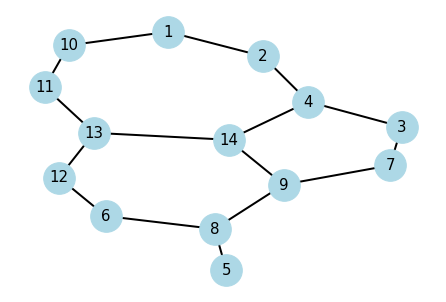

In [6]:
def printGrafo():
    # Crear un grafo dirigido
    G = nx.Graph()
    
    # Añadir nodos
    for node in nodos:
        G.add_node(node)
        
    for i, j in B:
        G.add_edge(i,j)
        
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', width=2, font_size=15)
    plt.show()

printGrafo()


## Modelo Matemático

### Variables del Problema
- $y_{ij}$ variable binaria que representa el *estado de la llave de interconexión* entre i y j, donde esta será 1 si la llave está abierta y 0 si se encuentra cerrada.  
- $P_{ij}$ variable continua que representa el flujo de *potencia activa* entre los nodos $i$ y $j$.
- $Q_{ij}$ variable continua que representa el flujo de *potencia reactiva* entre los nodos $i$ y $j$.
- $I_{ij}$ variable continua que representa el flujo de corriente entre los nodos $i$ y $j$.
- $V_{i}$ variable continua  representa el voltaje en el nodo $i$.


### Parámetros del Problema

- $P_{i}^{D}$ representa la demanda de potencia activa en el nodo $i$ 

- $Q_{i}^{D}$  representa la demanda de potencia  reactiva en el nodo $i$.

- $R_{ij}$ representa la resistencia de la linea entre los nodos $i$ y $j$ 

- $X_{ij}$ representa la reactancia de la linea entre los nodos $i$ y $j$.

## Creación del modelo

Para le modelo $t=1$.

In [7]:
# Create optimization model
m = gp.Model("RSD")
#Constantes

#tolerancia
tol=datos_globales.get("tol")

# b=lo que genera/consume cada nodo
b_v= 0.1


# tension minimima kV
vmin=float(datos_globales.get("vmin"))*float(datos_globales.get("vbase"))



# tension maxima kV
vmax= float(datos_globales.get("vmax"))*float(datos_globales.get("vbase"))

delV=vmax-vmin

# Potencia base kW
sbase= datos_globales.get("sbase")

print(vmin, vmax)
# Variables
# Estado de la llave del arco i y j
y =  m.addVars(nodos, nodos,  vtype=GRB.BINARY, name="y")

# Flujo de potencia activa entre los nodos i y j 
P =  m.addVars(nodos,nodos, vtype=GRB.CONTINUOUS,lb= 0, ub=1,  name="P")

# Flujo de potencia reactiva entre los nodos i y j 
Q = m.addVars(nodos,nodos,  vtype=GRB.CONTINUOUS,lb= 0, ub=1,  name="Q")

# Flujo de Corriente entre los nodos i y j
I = m.addVars(nodos,nodos,  vtype=GRB.CONTINUOUS, name="I")

# Valor al cuadrado del flujo de Corriente entre los nodos i y j
Isqr = m.addVars(nodos,nodos,  vtype=GRB.CONTINUOUS, lb= 0, ub=1, name="Isqr")

# Voltaje del nodo i
V = m.addVars(nodos,  vtype=GRB.CONTINUOUS, lb=vmin, ub=vmax, name="V")

# Valor al cuadrado del voltaje del nodo i
Vsqr = m.addVars(nodos, vtype=GRB.CONTINUOUS, lb=vmin**2, ub=vmax**2, name="Vsqr")

# Delta del V
deltaV= m.addVars(nodos, nodos, vtype=GRB.CONTINUOUS, lb=-delV, ub=delV, name="deltaV")


Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-22
21.39 24.150000000000002


In [8]:
#for (i, j) in B:
#    m.addConstr(Isqr[i, j]  == I[i, j] * I[i, j], name=f"sqr_constraint_I_{i}_{j}")
print(sbase)

100000.0


In [9]:
#for i in nodos:
#   m.addConstr(Vsqr[i] == V[i] * V[i], name=f"sqr_constraint_V_{i}_{j}")

In [10]:
m.update()

### Función Objetivo

$$
Min \sum\limits_{ij \in {B}} {{R_{ij}}I_{ij}^{2}};
$$


In [11]:
FO = LinExpr()
for (i, j) in B:
    FO += I[i,j]**2 * r[i, j]

m.setObjective(FO, GRB.MINIMIZE)
    

### Restricciones del problema

1. Equilibrio de potencia activa: esta restricción regula que la cantidad total de potencia activa que es consumida en el sistema eléctrico sea igual a la generada y entregada al sistema, además debe ser igual a la demandada del nodo. 

$$
\sum\limits_{ki \in {B}} {{P_{ki}}}   - \sum\limits_{ij \in {B}} {\left( {{P_{ij}} + {R_{ij}}I_{ij}^{2}} \right)} + P_{i,t}^S = P_{i,t}^D;\forall i \in {N}
$$

In [12]:
for i in nodos:    
    expr1 =0
    expr2 =0
    for k in nodos:
        if ((k,i) in B):
            expr1+=(P[k, i])
    
    for j in nodos:
        if ((i,j) in B):
            expr2+= P[i, j] + r[i, j] * I[i, j]**2
    
    
    r1 = expr1 - expr2 
    
    if(i!=int(datos_globales.get("nref"))):
        m.addConstr(r1 == pd[i]/sbase, name=f"demanda_potencia_activa _{i}")
    else:
        m.addConstr(r1 <= pd[i]/sbase, name=f"demanda_potencia_activa _{i}")

2. Equilibrio de potencia reactiva: permite que la cantidad total de potencia reactiva que es consumida en el sistema eléctrico sea igual a la generada y entregada al sistema y debe igualar la demanda del nodo.

$$
\sum\limits_{ki \in {B}} {{Q_{ki,t}}}   - \sum\limits_{ij \in {B}} {\left( {{Q_{ij,t}} + {X_{ij}}I_{ij,t}^{2}} \right)}  + Q_{i,t}^S= Q_{i,t}^D;\forall i \in {N},    \forall t \in {T}
$$ 

In [13]:
for i in nodos:
    
    expr1 =0
    expr2 =0
    for k in nodos:
        if ((k,i) in B):
            expr1+=(Q[k, i])
    
    for j in nodos:
        if ((i,j) in B):
            expr2+= Q[i, j] + x[i, j] * I[i, j]**2
    

    r1 = expr1 - expr2 
    

    if(i!=int(datos_globales.get("nref"))):
        m.addConstr(r1 == qd[i]/sbase, name=f"demanda_potencia_reactiva _{i}")
    else:
        m.addConstr(r1 <= qd[i]/sbase, name=f"demanda_potencia_reactiva _{i}")


3. Restricción del limite de la magnitud de tensión. El voltaje debe encontrarse entre un rango especifico. 

$$
{V_{i,t}^{sqr} = V_{j,t}^{sqr} + 2\left( {{R_{ij}}{P_{ij,t}} + {X_{ij}}{Q_{ij,t}}} \right)}- Z_{ij}^2{I_{ij,t}^{sqr}} + \Delta_{ij,t}^{V}; \forall ij \in {B},  \forall  t \in {T}
$$

$$
{V_{i}^{2} = V_{j}^{2} + 2\left( {{R_{ij}}{P_{ij}} + {X_{ij}}{Q_{ij}}} \right)}- (x_{ij}^2+r_{i,j}^2){I_{ij}^{2}} + \Delta_{ij}^{V}; \forall ij \in {B}
$$

$Z_{i,j}=x_{ij}^2+r_{i,j}^2$

In [14]:
for i,j in B: 
    expr1= 2*(P[(i, j)] * r[i,j] +Q[(i, j)] *x[i,j])
    expr2= (x[i,j]**2 + r[i,j]**2) *I[i,j]**2
    r3= V[(j)]**2 + expr1 - expr2 + deltaV[i,j]
    
    m.addConstr(Vsqr[i]==r3,name=f"limite de magnitud de tensión")
    


4. Restricción que permite regular la magnitud de tensión entre los nodos del sistema con respecto al estado de conexión/desconexión de las llaves de interconexión entre los nodos. 

$$
- {b^V}( {1 - {y_{ij}^B}}) \le \Delta _{ij}^V \le {b^V}( {1 -  {y_{ij}^B}});\forall ij \in B
$$
b= lo que genera/consume cada nodo


In [15]:
for (i,j) in B: 
    expr1= -b_v *(1 - y[i, j])
    m.addConstr(expr1 <= deltaV[(i, j)] ,name=f"regular la magnitud minima de tensión entre los nodos del sistema con respecto a las llaves")
    expr2 = b_v * (1 - y[i, j])
    m.addConstr(deltaV[(i, j)]<= expr2,name=f"regular la magnitud maxima de tensión entre los nodos del sistema con respecto a las llaves")

   

5. Restricción que permite que se sigan las leyes de la conservación de energía en el sistema eléctrico y tiene en cuenta la relación entre las magnitudes de tensión, corriente y potencias activas y reactivas
$$
V_{j}^{2} I_{ij}^{2} = P_{ij}^2 +  Q_{ij}^2;\forall ij \in {B}
$$

Esta se debe de linealizar, para lograr que sea una restricción optima de LP

In [16]:
for (i,j) in B:
    v1=V[j]**2
    v2=I[i, j]**2
    m.addConstr(Vsqr[j] * Isqr[i,j] == P[i, j] * P[i, j] + Q[i, j] * Q[i, j],
                    name=f"restriccion_cuadratica_{i}_{j}")

6. Conservación de potencia en el sistema eléctrico. 

$$
{ {\underline V }^2} \le V_{i}^{2} \le {\overline V }^2;\forall i \in N
$$

In [17]:
for i in nodos:
    m.addConstr(vmin**2<= V[i]**2, name =f" Conservación_minima_de_potencia_{i}")
    m.addConstr(Vsqr[i]<=vmax**2, name =f" Conservación_maxima_de_potencia_{i}")

7. Límites al cuadrado de la magnitud de la corriente entre los nodos i y j cuando la llave de interconexión se encuentre abierta. 

$$
0 \le I_{ij}^{2} \le \overline I_{ij}^2 y_{ij}^B;\forall ij \in {B}
$$

$  \overline I_{ij} = V_{max} / R_{i,j}$


In [18]:
for (i,j) in B:
    m.addConstr(0<=I[i,j]**2, name=f"magnitud_minima_Corriente_{i}_{j}")
    m.addConstr(I[i,j]**2<= (vmax/r[i,j])**2*y[i,j], name=f"magnitud_maxima_Corriente_{i}_{j}")
    

8. Restricción de la variable de estado de funcionamiento de los interruptores de interconexión $y_{ij,t}^B$.

$$
y_{ij,t}^B \in \left\{ {0,1} \right\};\forall ij \in {B}, \forall t \in {T}
$$

In [19]:
for (i,j) in B:
    m.addConstr((y[i,j]+y[j,i])<=1, name=f"solo_una_una_direccion_de_flujo_entre_los_nodos_{i}_{j}")

9. Restricción de radialidad

$$\sum_{ij \in B}{ y_{ij,t}^B} = |N|- |N_{sub}|$$

Para le caso Nsub= 1, entonces

$$\sum_{ij \in B}{ y_{ij,t}^B} = |N|- 1$$


In [20]:
print(nodos)
print(len(nodos))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
14


In [21]:
valor=0
print(len(nodos))

for (i,j) in B:
    valor+=y[i,j]
    
m.addConstr(valor ==(len(nodos)-1), name=f"Restriccione_de_radialidad")


14


<gurobi.Constr *Awaiting Model Update*>

In [22]:
"""for i in nodos: 
    suma=0
    if (i!=int(datos_globales.get("nref"))):
        for j in nodos: 
           if (i,j) in B: 
                suma+=y[j,i]
        m.addConstr(suma >=1, name=f"conexion{i}")
    else:
        for j in nodos: 
           if (i,j) in B: 
                suma+=y[i,j]
        m.addConstr(suma >=1, name=f"conexion{i}")

"""


'for i in nodos: \n    suma=0\n    if (i!=int(datos_globales.get("nref"))):\n        for j in nodos: \n           if (i,j) in B: \n                suma+=y[j,i]\n        m.addConstr(suma >=1, name=f"conexion{i}")\n    else:\n        for j in nodos: \n           if (i,j) in B: \n                suma+=y[i,j]\n        m.addConstr(suma >=1, name=f"conexion{i}")\n\n'

In [23]:
m.update()

In [24]:
m.setParam("NonConvex",2)

Set parameter NonConvex to value 2


In [25]:
m.optimize()

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8279U CPU @ 2.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 111 rows, 1204 columns and 238 nonzeros
Model fingerprint: 0x4f1a3c6b
Model has 32 quadratic objective terms
Model has 170 quadratic constraints
Variable types: 1008 continuous, 196 integer (196 binary)
Coefficient statistics:
  Matrix range     [1e-01, 1e+00]
  QMatrix range    [3e-03, 1e+00]
  QLMatrix range   [8e-02, 4e+05]
  Objective range  [0e+00, 0e+00]
  QObjective range [8e-02, 2e-01]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e-01, 6e+02]
  QRHS range       [1e-03, 5e+02]
Presolve removed 26 rows and 984 columns
Presolve time: 0.01s
Presolved: 634 rows, 362 columns, 1573 nonzeros
Presolved model has 3 quadratic objective terms
Presolved model has 31 quadratic constraint(s)
Presolved model has 143 bilinear constraint(s)
Variable types: 330 continuous, 32 

In [26]:
#m.computeIIS()

In [27]:
if m.Status == GRB.INFEASIBLE:
    m.computeIIS()
    m.write('iismodel.ilp')
    

In [28]:
m.write('modelo123.lp')

In [29]:
m.write('model.sol')

In [30]:
# Print out the IIS constraints and variables
print('\nThe following constraints and variables are in the IIS:')
for c in m.getConstrs():
    if c.IISConstr: 
        print(f'\t{c.constrname}: {m.getRow(c)} {c.Sense} {c.RHS}')


for v in m.getVars():

    if v.IISLB: print(f'\t{v.varname} ≥ {v.LB}')
    if v.IISUB: print(f'\t{v.varname} ≤ {v.UB}')


The following constraints and variables are in the IIS:


AttributeError: Unable to retrieve attribute 'IISConstr'

In [ ]:
def printGrafo():
    # Crear un grafo dirigido
    G = nx.Graph()
    
    # Añadir nodos
    for node in nodos:
        G.add_node(node)
    
    for i, j in B:
        if y[i,j].x>0:
            G.add_edge(i,j)
        
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', width=2, font_size=15)
    plt.show()

printGrafo()
print(m.objval)